# Review of classical electronic structure methods 

In order to assess the performance of quantum computing algorithms in addressing the electronic structure problem, we will briefly review a few commonly employed classical electronic structure methods of varying level of approximation. 

## Hartree-Fock

The Hartree-Fock (HF) method employs a **mean-field approximation**, where Coulomb correlation of electrons is neglected. The HF wavefunction is hence restricted to the form of a single Slater determinant, for which the optimal form may be acquired by an optimization of the underlying single particle basis (orbitals). Once the optimal HF orbitals have been found, the HF state may be written as 

$$ | \text{HF} \rangle = \prod_{p \in \text{occ}} \hat a^\dagger_p | \text{vac} \rangle $$

where $\hat a^\dagger_p$ creates an electron in the $p^{\rm{th}}$ optimized HF spin orbital, and  $| \text{vac} \rangle$ is the vacuum state (all spin-orbitals unoccupied). Due to the restriction to a single Slater determinant, the HF energy may be obtained very efficiently and can be applied to very large molecules, however it becomes qualitatively incorrect when **electronic correlations** become sufficiently strong. The HF wavefunction is often used as a starting point in more accurate treatments of electronic correlation. 

## Coupled cluster

The Coupled cluster (CC) method introduces electronic correlation to the wavefunction ansatz by operating on the HF reference state with the exponential of excitation operators

$$|\text{CC} \rangle = e^{\hat T} | \text{HF}\rangle, \quad \hat T = \hat T_1 + \hat T_2 + ...$$

where $\hat T_1 = \sum_{ia} t^{a}_i \hat a^\dagger_a \hat a_i$ are referred to as 'singles', $\hat T_2 = \sum_{ijab} t^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j$ as 'doubles', etc. When the excitation rank is truncated to only singles (S) and doubles (D), $\hat T = \hat T_1 + \hat T_2$, the corresponding ansatz is referred to as CCSD. Since the number of possible single and double excitations for a system of $N$ electrons in $M$ orbitals is polynomial in $M$, one can efficiently solve a system of equations to obtain the optimized CCSD amplitudes. CCSD often gives accurate energies and can be applied to modestly sized chemical systems. However, due to its implementation, it can **violate the variational principle** and give energies lower than the ground state.

## Full Configuration Interaction
The full configuration interaction (FCI) method yields the **exact ground state energy** within a given basis set. The FCI wavefunction is written as a linear combination of all possible $N$-particle Slater determinants over the orbital basis
$$|\text{FCI} \rangle =  \left( \sum_{ia} C^{a}_i \hat a^\dagger_a \hat a_i + \sum_{ijab} C^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j + ...  \right) | \text{HF} \rangle $$
where the sum includes up to $N$-electron excitations, and hence there are an exponential number of coefficients to optimize in $| \text{FCI} \rangle$. Due to its **exponential complexity**, FCI is often reserved for only the smallest chemical systems. However, it serves as a useful result to compare to when assessing tractable electronic structure methods.

# Benchmarking for electronic PESs in minimal basis (STO-3G)

We will apply HF, CCSD, and FCI to obtaining the PESs for a few molecular dissociation processes in minimal (STO-3G) basis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utility import get_molecular_data, obtain_PES

basis = 'sto-3g'

/home/ushnish/.local/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


## H<sub>2</sub>

In [32]:
bond_lengths = np.linspace(0.2,2.6,15)

In [33]:
#Run FCI
FCI_PES = obtain_PES('h2', bond_lengths, basis, method='fci')

converged SCF energy = 0.164175012061695
E = 0.15748213479836348 Eh
converged SCF energy = -0.839684083956067
E = -0.8488991057547286 Eh
converged SCF energy = -1.07486102490599
E = -1.0882281842437163 Eh
converged SCF energy = -1.11750157922789
E = -1.1369289593879264 Eh
converged SCF energy = -1.09513510118901
E = -1.1229570528666362 Eh
converged SCF energy = -1.04953250777026
E = -1.0887645366068759 Eh
converged SCF energy = -0.995976005034107
E = -1.050442037345773 Eh
converged SCF energy = -0.941480654707798
E = -1.0154682492882445 Eh
converged SCF energy = -0.889889958382754
E = -0.9873930556257475 Eh
converged SCF energy = -0.843174458569733
E = -0.9670259116896882 Eh
converged SCF energy = -0.80213543384489
E = -0.953424238929029 Eh
converged SCF energy = -0.766864889751915
E = -0.9449089871327179 Eh
converged SCF energy = -0.737027158095765
E = -0.9398197912427146 Eh
converged SCF energy = -0.712060259734193
E = -0.9368706035430501 Eh
converged SCF energy = -0.691327561197377


In [34]:
#Run HF
HF_PES = obtain_PES('h2', bond_lengths, basis,  method='hf')

converged SCF energy = 0.164175012061695
converged SCF energy = 0.164175012061696
E = 0.16417501206169582 Eh
converged SCF energy = -0.839684083956067
converged SCF energy = -0.839684083956067
E = -0.8396840839560673 Eh
converged SCF energy = -1.07486102490599
converged SCF energy = -1.07486102490599
E = -1.0748610249059865 Eh
converged SCF energy = -1.11750157922789
converged SCF energy = -1.11750157922789
E = -1.1175015792278884 Eh
converged SCF energy = -1.09513510118901
converged SCF energy = -1.09513510118901
E = -1.0951351011890111 Eh
converged SCF energy = -1.04953250777026
converged SCF energy = -1.04953250777026
E = -1.0495325077702624 Eh
converged SCF energy = -0.995976005034107
converged SCF energy = -0.995976005034107
E = -0.9959760050341071 Eh
converged SCF energy = -0.941480654707798
converged SCF energy = -0.941480654707798
E = -0.9414806547077981 Eh
converged SCF energy = -0.889889958382754
converged SCF energy = -0.889889958382754
E = -0.889889958382754 Eh
converged SC

In [35]:
#Run CCSD
CCSD_PES = obtain_PES('h2', bond_lengths, basis,  method='ccsd')

converged SCF energy = 0.164175012061695
E(CCSD) = 0.1574821318755476  E_corr = -0.00669288018614819
E = 0.15748213187554763 Eh
converged SCF energy = -0.839684083956067
E(CCSD) = -0.8488991194884047  E_corr = -0.009215035532337343
E = -0.8488991194884047 Eh
converged SCF energy = -1.07486102490599
E(CCSD) = -1.088228226369218  E_corr = -0.01336720146323128
E = -1.0882282263692178 Eh
converged SCF energy = -1.11750157922789
E(CCSD) = -1.136929092564818  E_corr = -0.01942751333692954
E = -1.136929092564818 Eh
converged SCF energy = -1.09513510118901
E(CCSD) = -1.122957052870124  E_corr = -0.0278219516811127
E = -1.1229570528701238 Eh
converged SCF energy = -1.04953250777026
E(CCSD) = -1.088764536633295  E_corr = -0.03923202886303246
E = -1.088764536633295 Eh
converged SCF energy = -0.995976005034107
E(CCSD) = -1.050442037622604  E_corr = -0.05446603258849664
E = -1.0504420376226038 Eh
converged SCF energy = -0.941480654707798
E(CCSD) = -1.015468249381512  E_corr = -0.07398759467371405
E

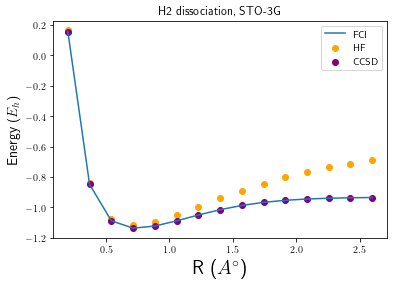

In [36]:
#Plot H2 PESs

plt.title('H2 dissociation, STO-3G')
plt.xlabel(r'R ($A^\circ$)',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend()

<img src="figs/testimage.png">

## H<sub>2</sub>O symmetric O-H dissociation

In [7]:
bond_lengths = np.linspace(0.5,2.7,15)

In [38]:
#Run FCI
FCI_PES = obtain_PES('h2o', bond_lengths, basis, method='fci')

converged SCF energy = -56.177972428718
E = -56.181527059700244 Eh
converged SCF energy = -70.1388290093913
E = -70.14690888135627 Eh
converged SCF energy = -73.6465715473326
E = -73.66199728605835 Eh
converged SCF energy = -74.6656253842167
E = -74.6912927856763 Eh
converged SCF energy = -74.9364373640549
E = -74.97710169934528 Eh
converged SCF energy = -74.9533865123646
E = -75.01662841302804 Eh
converged SCF energy = -74.8769000828631
E = -74.97264454927941 Eh
converged SCF energy = -74.7689574519789
E = -74.9081561690947 Eh
converged SCF energy = -74.6544986158641
E = -74.84803818169853 Eh
converged SCF energy = -74.5443681119313
E = -74.80178045835092 Eh
converged SCF energy = -74.4447494379006
E = -74.7716151519376 Eh
converged SCF energy = -74.3582594374013
E = -74.7546596926045 Eh
converged SCF energy = -74.286557245631
E = -74.7459874234592 Eh
converged SCF energy = -74.2279330707091
E = -74.64050032178153 Eh
SCF not converged.
SCF energy = -72.9472562025615
E = -74.7383127453

In [39]:
#Run HF
HF_PES = obtain_PES('h2o', bond_lengths, basis,  method='hf')

converged SCF energy = -56.1779724287181
converged SCF energy = -56.177972428718
E = -56.17797242871802 Eh
converged SCF energy = -70.1388290093914
converged SCF energy = -70.1388290093914
E = -70.13882900939137 Eh
converged SCF energy = -73.6465715473326
converged SCF energy = -73.6465715473326
E = -73.64657154733264 Eh
converged SCF energy = -74.6656253842167
converged SCF energy = -74.6656253842167
E = -74.66562538421671 Eh
converged SCF energy = -74.9364373640549
converged SCF energy = -74.9364373640549
E = -74.93643736405491 Eh
converged SCF energy = -74.9533865123646
converged SCF energy = -74.9533865123646
E = -74.95338651236456 Eh
converged SCF energy = -74.8769000828631
converged SCF energy = -74.8769000828631
E = -74.87690008286314 Eh
converged SCF energy = -74.7689574519789
converged SCF energy = -74.768957451979
E = -74.76895745197898 Eh
converged SCF energy = -74.6544986158641
converged SCF energy = -74.6544986158641
E = -74.65449861586414 Eh
converged SCF energy = -74.544

In [40]:
#Run CCSD
CCSD_PES = obtain_PES('h2o', bond_lengths, basis,  method='ccsd')

converged SCF energy = -56.177972428718
E(CCSD) = -56.18152625999694  E_corr = -0.003553831278931532
E = -56.181526259996936 Eh
converged SCF energy = -70.1388290093913
E(CCSD) = -70.14689935485202  E_corr = -0.008070345460629926
E = -70.14689935485202 Eh
converged SCF energy = -73.6465715473326
E(CCSD) = -73.66197483320614  E_corr = -0.01540328587353763
E = -73.66197483320614 Eh
converged SCF energy = -74.6656253842167
E(CCSD) = -74.69124734031904  E_corr = -0.02562195610233203
E = -74.69124734031904 Eh
converged SCF energy = -74.9364373640549
E(CCSD) = -74.97700979350323  E_corr = -0.04057242944830097
E = -74.97700979350323 Eh
converged SCF energy = -74.9533865123645
E(CCSD) = -75.01643788020911  E_corr = -0.0630513678445996
E = -75.01643788020911 Eh
converged SCF energy = -74.8769000828631
E(CCSD) = -74.97221857444369  E_corr = -0.09531849158048389
E = -74.97221857444369 Eh
converged SCF energy = -74.7689574519789
E(CCSD) = -74.90733493633432  E_corr = -0.1383774843553606
E = -74.90

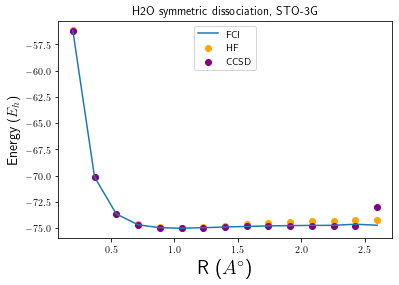

In [41]:
#Plot H2O PESs

plt.title('H2O symmetric dissociation, STO-3G')
plt.xlabel(r'R ($A^\circ$)',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend(loc = 'upper center')

Next we compute the PEs for other types of molecules
$LiH$, $N_2$, $H_4$, and $NH_3$

$LiH$

$r_0 = 1.619$ Angstrom

In [42]:
#Starting with LiH
#r_eqb = 1.619 Ang
bond_lengths = [x for x in np.linspace(1.0,1.619,7)] 
bond_lengths = bond_lengths[:-1]
bond_lengths += [x for x in np.linspace(1.619,2.7,8)]
print(bond_lengths)


[1.0, 1.1031666666666666, 1.2063333333333333, 1.3094999999999999, 1.4126666666666667, 1.5158333333333334, 1.619, 1.7734285714285714, 1.927857142857143, 2.0822857142857143, 2.2367142857142857, 2.3911428571428575, 2.545571428571429, 2.7]


In [43]:
#Run FCI
FCI_PES = obtain_PES('lih', bond_lengths, basis, method='fci')

converged SCF energy = -7.76736213574856
E = -7.784460280031223 Eh
converged SCF energy = -7.80979176463783
E = -7.826581033120969 Eh
converged SCF energy = -7.83692872384727
E = -7.853756740401657 Eh
converged SCF energy = -7.85306658932547
E = -7.8703065130887655 Eh
converged SCF energy = -7.86118008465405
E = -7.879213083453225 Eh
converged SCF energy = -7.86337692068677
E = -7.882587446751686 Eh
converged SCF energy = -7.86118812320016
E = -7.881966102188465 Eh
converged SCF energy = -7.85210876795008
E = -7.875986257595848 Eh
converged SCF energy = -7.83838177201205
E = -7.866316816255432 Eh
converged SCF energy = -7.82179682213268
E = -7.854833029562911 Eh
converged SCF energy = -7.80355661022601
E = -7.842840943624413 Eh
converged SCF energy = -7.78448734730311
E = -7.831267953080062 Eh
converged SCF energy = -7.76517971175667
E = -7.820764021417497 Eh
converged SCF energy = -7.74607970736099
E = -7.811735339124828 Eh


In [44]:
#Run HF
HF_PES = obtain_PES('lih', bond_lengths, basis,  method='hf')

converged SCF energy = -7.76736213574856
converged SCF energy = -7.76736213574858
E = -7.767362135748578 Eh
converged SCF energy = -7.80979176463783
converged SCF energy = -7.80979176463784
E = -7.809791764637841 Eh
converged SCF energy = -7.83692872384727
converged SCF energy = -7.83692872384728
E = -7.836928723847279 Eh
converged SCF energy = -7.85306658932547
converged SCF energy = -7.8530665893276
E = -7.853066589327602 Eh
converged SCF energy = -7.86118008465405
converged SCF energy = -7.86118008465472
E = -7.861180084654718 Eh
converged SCF energy = -7.86337692068677
converged SCF energy = -7.86337692068678
E = -7.863376920686776 Eh
converged SCF energy = -7.86118812320016
converged SCF energy = -7.86118812320016
E = -7.861188123200161 Eh
converged SCF energy = -7.85210876795007
converged SCF energy = -7.85210876795008
E = -7.85210876795008 Eh
converged SCF energy = -7.83838177201205
converged SCF energy = -7.83838177201205
E = -7.838381772012054 Eh
converged SCF energy = -7.8217

In [45]:
#Run CCSD
CCSD_PES = obtain_PES('lih', bond_lengths, basis,  method='ccsd')

converged SCF energy = -7.76736213574856
E(CCSD) = -7.784454825910823  E_corr = -0.01709269016226168
E = -7.7844548259108235 Eh
converged SCF energy = -7.80979176463783
E(CCSD) = -7.826575204641606  E_corr = -0.01678344000377568
E = -7.826575204641606 Eh
converged SCF energy = -7.83692872384727
E(CCSD) = -7.853750205060464  E_corr = -0.01682148121319228
E = -7.853750205060464 Eh
converged SCF energy = -7.85306658932547
E(CCSD) = -7.870299079621435  E_corr = -0.01723249029595917
E = -7.870299079621435 Eh
converged SCF energy = -7.86118008465405
E(CCSD) = -7.879204638475541  E_corr = -0.01802455382149376
E = -7.8792046384755405 Eh
converged SCF energy = -7.86337692068677
E(CCSD) = -7.882577891331051  E_corr = -0.01920097064427495
E = -7.882577891331051 Eh
converged SCF energy = -7.86118812320016
E(CCSD) = -7.881955303298596  E_corr = -0.02076718009844027
E = -7.881955303298596 Eh
converged SCF energy = -7.85210876795008
E(CCSD) = -7.8759731988542  E_corr = -0.02386443090412347
E = -7.875

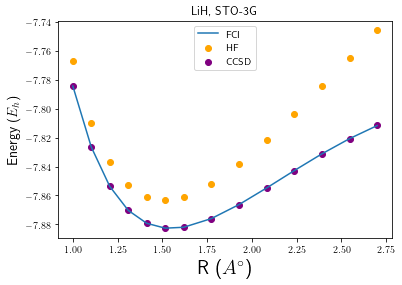

In [46]:
#Plot LiH PESs
plt.title('LiH, STO-3G')
plt.xlabel(r'R ($A^\circ$)',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend(loc = 'upper center')

$N_2$

$𝑟_0 = 1.119$ Angstrom

In [47]:
bond_lengths = [x for x in np.linspace(1.0,1.119,7)] 
bond_lengths += [x for x in np.linspace(1.120,1.5,8)]
print(bond_lengths)

[1.0, 1.0198333333333334, 1.0396666666666667, 1.0594999999999999, 1.0793333333333333, 1.0991666666666666, 1.119, 1.12, 1.1742857142857144, 1.2285714285714286, 1.282857142857143, 1.3371428571428572, 1.3914285714285715, 1.4457142857142857, 1.5]


In [48]:
#Run FCI
FCI_PES = obtain_PES('n2', bond_lengths, basis, method='fci')

converged SCF energy = -107.419532451682
E = -107.54930095790854 Eh
converged SCF energy = -107.44439201994
E = -107.57936182589182 Eh
converged SCF energy = -107.463939801382
E = -107.60426977073314 Eh
converged SCF energy = -107.478762050244
E = -107.62461218152748 Eh
converged SCF energy = -107.489386014866
E = -107.64091702373275 Eh
converged SCF energy = -107.496285635961
E = -107.65365858481638 Eh
converged SCF energy = -107.499886689299
E = -107.66326266182561 Eh
converged SCF energy = -107.4999879992
E = -107.66367090726257 Eh
converged SCF energy = -107.495586402914
E = -107.67654317744656 Eh
converged SCF energy = -107.475732233152
E = -107.67515353271179 Eh
converged SCF energy = -107.445164146148
E = -107.66422167708389 Eh
converged SCF energy = -107.407355286627
E = -107.64720402800936 Eh
converged SCF energy = -107.364832439239
E = -107.62662139272163 Eh
converged SCF energy = -107.319423462319
E = -107.60431377607699 Eh
converged SCF energy = -107.272448501206
E = -107.5

In [49]:
#Run HF
HF_PES = obtain_PES('n2', bond_lengths, basis,  method='hf')

converged SCF energy = -107.419532451682
converged SCF energy = -107.419532451682
E = -107.41953245168213 Eh
converged SCF energy = -107.44439201994
converged SCF energy = -107.44439201994
E = -107.44439201993978 Eh
converged SCF energy = -107.463939801382
converged SCF energy = -107.463939801382
E = -107.46393980138205 Eh
converged SCF energy = -107.478762050244
converged SCF energy = -107.478762050244
E = -107.47876205024448 Eh
converged SCF energy = -107.489386014866
converged SCF energy = -107.489386014866
E = -107.48938601486637 Eh
converged SCF energy = -107.496285635961
converged SCF energy = -107.496285635962
E = -107.49628563596153 Eh
converged SCF energy = -107.499886689299
converged SCF energy = -107.499886689299
E = -107.49988668929917 Eh
converged SCF energy = -107.4999879992
converged SCF energy = -107.499987999199
E = -107.49998799919948 Eh
converged SCF energy = -107.495586402914
converged SCF energy = -107.495586402914
E = -107.4955864029143 Eh
converged SCF energy = -

In [50]:
#Run CCSD
CCSD_PES = obtain_PES('n2', bond_lengths, basis,  method='ccsd')

converged SCF energy = -107.419532451682
E(CCSD) = -107.5467229244351  E_corr = -0.1271904727529142
E = -107.54672292443507 Eh
converged SCF energy = -107.44439201994
E(CCSD) = -107.5765596109187  E_corr = -0.1321675909789162
E = -107.57655961091872 Eh
converged SCF energy = -107.463939801382
E(CCSD) = -107.6012234804558  E_corr = -0.137283679073766
E = -107.60122348045581 Eh
converged SCF energy = -107.478762050245
E(CCSD) = -107.6213005619512  E_corr = -0.1425385117067028
E = -107.62130056195122 Eh
converged SCF energy = -107.489386014866
E(CCSD) = -107.6373174734537  E_corr = -0.1479314585873445
E = -107.63731747345372 Eh
converged SCF energy = -107.496285635962
E(CCSD) = -107.6497471873566  E_corr = -0.1534615513951123
E = -107.64974718735664 Eh
converged SCF energy = -107.499886689299
E(CCSD) = -107.6590144349553  E_corr = -0.1591277456561059
E = -107.65901443495525 Eh
converged SCF energy = -107.4999879992
E(CCSD) = -107.6594050161181  E_corr = -0.1594170169184675
E = -107.659405

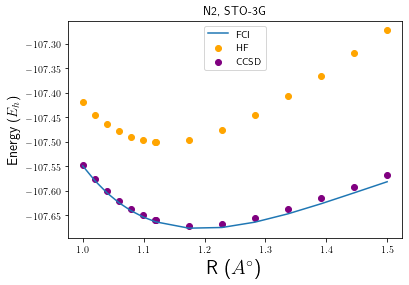

In [51]:
#Plot N2 PESs

plt.title('N2, STO-3G')
plt.xlabel(r'R ($A^\circ$)',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend(loc = 'upper center')

$H_4$

In [52]:
bond_angles = np.linspace(15.0,40.0,15)

In [53]:
#Run FCI
FCI_PES = obtain_PES('h4', bond_angles, basis, method='fci')

converged SCF energy = -1.98488287113067
E = -2.006871858726831 Eh
converged SCF energy = -2.09869359325099
E = -2.1234259293315123 Eh
converged SCF energy = -2.16974452446787
E = -2.1975716022716236 Eh
converged SCF energy = -2.21079297346973
E = -2.2420835314321894 Eh
converged SCF energy = -2.23046557734084
E = -2.265606646260297 Eh
converged SCF energy = -2.23480486317451
E = -2.2742036932991425 Eh
converged SCF energy = -2.22812531339812
E = -2.2722128688015872 Eh
converged SCF energy = -2.21352563644555
E = -2.2627613950641274 Eh
converged SCF energy = -2.19322972320541
E = -2.248106803985646 Eh
converged SCF energy = -2.16883474963959
E = -2.229884084719856 Eh
converged SCF energy = -2.1414981254735
E = -2.2092905344194027 Eh
converged SCF energy = -2.11207597728273
E = -2.1872214195136466 Eh
converged SCF energy = -2.0812208880512
E = -2.1643646561294316 Eh
converged SCF energy = -2.04944679011668
E = -2.1412628045773516 Eh
converged SCF energy = -2.017169537283
E = -2.11835115

In [54]:
#Run HF
HF_PES = obtain_PES('h4', bond_angles, basis,  method='hf')

converged SCF energy = -1.98488287113067
converged SCF energy = -1.98488287113067
E = -1.9848828711306745 Eh
converged SCF energy = -2.09869359325099
converged SCF energy = -2.09869359325099
E = -2.098693593250987 Eh
converged SCF energy = -2.16974452446787
converged SCF energy = -2.16974452446787
E = -2.169744524467869 Eh
converged SCF energy = -2.21079297346973
converged SCF energy = -2.21079297346973
E = -2.210792973469727 Eh
converged SCF energy = -2.23046557734084
converged SCF energy = -2.23046557734084
E = -2.2304655773408415 Eh
converged SCF energy = -2.23480486317451
converged SCF energy = -2.23480486317452
E = -2.2348048631745154 Eh
converged SCF energy = -2.22812531339812
converged SCF energy = -2.22812531339812
E = -2.22812531339812 Eh
converged SCF energy = -2.21352563644555
converged SCF energy = -2.21352563644555
E = -2.2135256364455485 Eh
converged SCF energy = -2.19322972320541
converged SCF energy = -2.19322972320541
E = -2.1932297232054054 Eh
converged SCF energy = -

In [55]:
#Run CCSD
CCSD_PES = obtain_PES('h4', bond_angles, basis,  method='ccsd')

converged SCF energy = -1.98488287113067
E(CCSD) = -2.006871841316002  E_corr = -0.02198897018532968
E = -2.0068718413160025 Eh
converged SCF energy = -2.09869359325099
E(CCSD) = -2.123425898104841  E_corr = -0.02473230485385378
E = -2.123425898104841 Eh
converged SCF energy = -2.16974452446787
E(CCSD) = -2.197571547363218  E_corr = -0.0278270228953489
E = -2.197571547363218 Eh
converged SCF energy = -2.21079297346973
E(CCSD) = -2.242083473777973  E_corr = -0.0312905003082463
E = -2.2420834737779733 Eh
converged SCF energy = -2.23046557734084
E(CCSD) = -2.26560654896613  E_corr = -0.03514097162528882
E = -2.2656065489661303 Eh
converged SCF energy = -2.23480486317451
E(CCSD) = -2.274203600315103  E_corr = -0.03939873714058855
E = -2.274203600315103 Eh
converged SCF energy = -2.22812531339812
E(CCSD) = -2.272212799016382  E_corr = -0.04408748561826143
E = -2.272212799016382 Eh
converged SCF energy = -2.21352563644555
E(CCSD) = -2.262761351687927  E_corr = -0.04923571524238162
E = -2.262

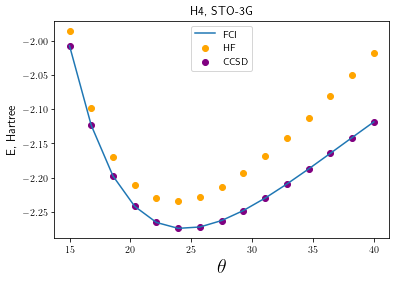

In [56]:
#Plot H4 PESs
import matplotlib
matplotlib.rcParams['text.usetex'] = True

plt.title('H4, STO-3G')
plt.xlabel(r'$\theta$',fontsize=20)
plt.ylabel('E, Hartree',fontsize=12)

plt.plot(bond_angles, FCI_PES, label='FCI')
plt.scatter(bond_angles, HF_PES, label='HF', color='orange')
plt.scatter(bond_angles, CCSD_PES, label='CCSD', color='purple')
plt.legend(loc = 'upper center')

$NH_3$

$r_0 = 1.008$

In [105]:
bond_lengths = [x for x in np.linspace(0.9,1.008,7)] 
bond_lengths += [x for x in np.linspace(1.009,1.25,8)]
print(bond_lengths)

[0.9, 0.918, 0.936, 0.954, 0.972, 0.99, 1.008, 1.009, 1.0434285714285714, 1.0778571428571428, 1.112285714285714, 1.1467142857142856, 1.181142857142857, 1.2155714285714285, 1.25]


In [106]:
#Run FCI
FCI_PES = obtain_PES('nh3', bond_lengths, basis, method='fci')

converged SCF energy = -55.3923579267289
E = -55.44295420403765 Eh
converged SCF energy = -55.4103046515789
E = -55.4629829618822 Eh
converged SCF energy = -55.424733431716
E = -55.47957405669433 Eh
converged SCF energy = -55.4359800143823
E = -55.49306717972141 Eh
converged SCF energy = -55.4443461985275
E = -55.503768239502534 Eh
converged SCF energy = -55.4501037627585
E = -55.511953284044836 Eh
converged SCF energy = -55.4534979374946
E = -55.51787196628814 Eh
converged SCF energy = -55.4536217639898
E = -55.51813897924335 Eh
converged SCF energy = -55.4541120603298
E = -55.523756170106935 Eh
converged SCF energy = -55.4481363637607
E = -55.52331346511703 Eh
converged SCF energy = -55.4368155136003
E = -55.51796661534382 Eh
converged SCF energy = -55.4210912634011
E = -55.508693456097006 Eh
converged SCF energy = -55.4017589901499
E = -55.49632608316294 Eh
converged SCF energy = -55.3794925103696
E = -55.48157492642135 Eh
converged SCF energy = -55.3548631222389
E = -55.46504680697

In [107]:
#Run HF
HF_PES = obtain_PES('nh3', bond_lengths, basis,  method='hf')

converged SCF energy = -55.3923579267289
converged SCF energy = -55.392357926729
E = -55.39235792672896 Eh
converged SCF energy = -55.4103046515789
converged SCF energy = -55.4103046515791
E = -55.41030465157906 Eh
converged SCF energy = -55.424733431716
converged SCF energy = -55.4247334317161
E = -55.424733431716106 Eh
converged SCF energy = -55.4359800143823
converged SCF energy = -55.4359800143823
E = -55.43598001438234 Eh
converged SCF energy = -55.4443461985276
converged SCF energy = -55.4443461985276
E = -55.44434619852758 Eh
converged SCF energy = -55.4501037627585
converged SCF energy = -55.4501037627586
E = -55.45010376275856 Eh
converged SCF energy = -55.4534979374946
converged SCF energy = -55.4534979374945
E = -55.45349793749452 Eh
converged SCF energy = -55.4536217639898
converged SCF energy = -55.4536217639898
E = -55.453621763989766 Eh
converged SCF energy = -55.4541120603298
converged SCF energy = -55.4541120603298
E = -55.45411206032985 Eh
converged SCF energy = -55.4

In [108]:
#Run CCSD
CCSD_PES = obtain_PES('nh3', bond_lengths, basis,  method='ccsd')

converged SCF energy = -55.3923579267289
E(CCSD) = -55.4428381673422  E_corr = -0.05048024061331503
E = -55.442838167342195 Eh
converged SCF energy = -55.4103046515789
E(CCSD) = -55.46285547864381  E_corr = -0.0525508270649194
E = -55.46285547864381 Eh
converged SCF energy = -55.424733431716
E(CCSD) = -55.47943366501288  E_corr = -0.05470023329682066
E = -55.479433665012884 Eh
converged SCF energy = -55.4359800143823
E(CCSD) = -55.49291225050334  E_corr = -0.05693223612110081
E = -55.49291225050334 Eh
converged SCF energy = -55.4443461985276
E(CCSD) = -55.5035969655107  E_corr = -0.05925076698312437
E = -55.503596965510695 Eh
converged SCF energy = -55.4501037627585
E(CCSD) = -55.5117636695996  E_corr = -0.06165990684105681
E = -55.5117636695996 Eh
converged SCF energy = -55.4534979374945
E(CCSD) = -55.51766181875583  E_corr = -0.06416388126133632
E = -55.517661818755826 Eh
converged SCF energy = -55.4536217639898
E(CCSD) = -55.51792762262781  E_corr = -0.06430585863804383
E = -55.5179

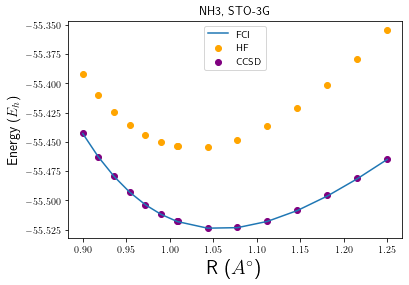

In [109]:
#Plot NH3 PESs
import matplotlib
matplotlib.rcParams['text.usetex'] = True

plt.title('NH3, STO-3G')
plt.xlabel(r'R ($A^\circ$)',fontsize=20)
plt.ylabel(r'Energy ($E_h$)',fontsize=14)

plt.plot(bond_lengths, FCI_PES, label='FCI')
plt.scatter(bond_lengths, HF_PES, label='HF', color='orange')
plt.scatter(bond_lengths, CCSD_PES, label='CCSD', color='purple')
plt.legend(loc = 'upper center')